# Homework: Titanic survival dataset exploration

Your goal is to fill #TODO places with your code and answer questions  

Here are some features that can help you determine who survived in Titanic.  
Our quality metric - area under the roc curve

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

SEED = 1337
# !!you should use that seed in all models which accepts random_state

In [74]:
df = pd.read_csv('./train.csv', index_col=0)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## fill missing values

In [75]:
# TODO 1:
# encode Sex column
# hint: use LabelEncoder
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['Sex'] = encoder.fit_transform(df['Sex'])


In [76]:
# print columns with missing values
for name in df.columns:
    print(name, np.sum(pd.isnull(df[name])))

Survived 0
Pclass 0
Name 0
Sex 0
Age 177
SibSp 0
Parch 0
Ticket 0
Fare 0
Cabin 687
Embarked 2


In [77]:
# Replace missing values with "unkown"
df.loc[df.Cabin.isnull(), 'Cabin'] = 'unknown'

# fill Fare with median value
df.loc[ np.isnan(df['Fare']), 'Fare'] = df['Fare'].median()

# TODO 2
# Replace missing values in Embarked column with most common port
# hint: use Series.mode method

df.loc[ df.Embarked.isnull(), 'Embarked' ] = df['Embarked'].mode()[0]

In [78]:
# TODO 3
# train Random Forest regression model to fill missing values in Age column
# use  100 estimators, set oob_score in True, other params by default
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

age_columns = ['Age', 'Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 
       'Fare', 'Embarked']

age_df = df[age_columns]

age_df['Embarked'] = preprocessing.LabelEncoder().fit_transform(age_df['Embarked'])
train_df = age_df.loc[age_df.Age.notnull()]
test_df = age_df.loc[age_df.Age.isnull()]
print('train age', train_df.shape[0])
print('test age', test_df.shape[0])

model_rf = RandomForestRegressor(n_estimators=100,oob_score=True,random_state=SEED)
model_rf.fit(train_df.drop('Age',axis=1),train_df.Age)

df.loc[df.Age.isnull(), 'Age'] = model_rf.predict(test_df.drop('Age',axis=1))

C:\Users\user\AppData\Local\Programs\Python\Python36-32\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


train age 714
test age 177


### Question 1: what is the oob_score of trained model?

In [79]:
model_forest.oob_score_

AttributeError: 'RandomForestClassifier' object has no attribute 'oob_score_'

## feature transformation

In [80]:
# TODO 4
# Create a dataframe of dummy variables for each distinct value of Embarked
# hint: use DataFrame.get_dummies method

# Rename the columns from 'S', 'C', 'Q' to 'Embarked_S', 'Embarked_C', 'Embarked_Q'
# hint: use pandas.rename method

# Add the new dummy variables back to the original data set
# hint: use pandas.concat method

df_dummy = pd.get_dummies(df['Embarked'])
df_dummy = df_dummy.rename(columns={'S':'Embarked_S', 'C':'Embarked_C', 'Q':'Embarked_Q'})
df = pd.concat([df, df_dummy], axis=1)


df['Embarked'] = preprocessing.LabelEncoder().fit_transform(df['Embarked'])
 

In [81]:
# TODO 5

# create feature for the alphabetical part of the cabin number
# hint: use re module
 
# convert the distinct cabin letters with incremental integer values
# hint: use pandas.factorize method
import re

df['CabinLetter']=pd.Series([re.search('([A-Za-z]+)', i).group(1) for i in df['Cabin']])
df['CabinLetter'] = pd.factorize(df['CabinLetter'])[0]

df['Cabin'] = preprocessing.LabelEncoder().fit_transform(df['Cabin'])

In [82]:
# TODO 6

# Divide all fares into quartiles
# hint: use pandas.qcut

# create dummies from the result and add tham to dataset

fare_q = pd.qcut(df['Fare'],q=4)
fare_dummies = pd.get_dummies(fare_q)
df = pd.concat((df,fare_dummies),axis=1)

In [83]:
df = df.drop(['Name', 'Ticket'], axis=1)
df.shape

(891, 17)

In [84]:
# TODO 7
# make dimension reduction with PCA, leave enough components to explain 98% variance of the data, 
# other params by default. Project dataset on these components
# Of course, you should not project your target variable

X = df.drop('Survived',axis=1)
y = df['Survived']

for n in range(1, 10):
    pca = PCA(n_components=n, random_state=SEED)
    X_pca = pca.fit_transform(X)

    if sum(pca.explained_variance_ratio_) >= 0.98:
        print('components number: ', n) 
        print('explaned ratio: ', sum(pca.explained_variance_ratio_))
        break

components number:  3
explaned ratio:  0.9984562593969076


### Question 2: how many components are in PCA?

There are 3 components

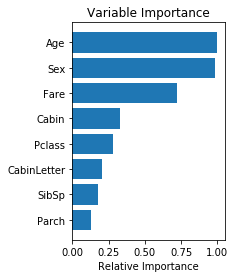

In [85]:
# TODO 8
# plot feature importances from Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


X = df.drop('Survived', axis=1)
y = df.Survived.values
features_list = X.columns
X = X.as_matrix()
 
# Train Random Forest Classifier on datasert with 5000 trees, other params by default
# get feature importances from model

model_forest = RandomForestClassifier(n_estimators=5000, random_state=SEED)
model_forest.fit(X, y)
feature_importance = model_forest.feature_importances_
 
# make importances relative to max importance
feature_importance = feature_importance / feature_importance.max()
 
# A threshold below which to drop features from the final data set. Specifically, this number represents
# the percentage of the most important feature's importance value
fi_threshold = 0.10
 
# Get the indexes of all features over the importance threshold

important_idx = [i for i in range(len(feature_importance)) if feature_importance[i] > fi_threshold]
 
# Create a list of all the feature names above the importance threshold
important_features = features_list[important_idx]
 
# Get the sorted indexes of important features
sorted_idx = np.argsort(feature_importance[important_idx])[::-1]
 

pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[important_idx][sorted_idx[::-1]], align='center')
plt.yticks(pos, important_features[sorted_idx[::-1]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.draw()
plt.show()
 
# Remove non-important features from the feature set
X = X[:,important_idx]

### Question 3: What are 4 top most important features?##

1. Age, 2. Sex, 3. Fare, 4. Cabin

In [86]:
# stack features

X = np.hstack([X, X_pca])
X.shape

(891, 11)

<module 'matplotlib.pyplot' from 'C:\\Users\\user\\AppData\\Local\\Programs\\Python\\Python36-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

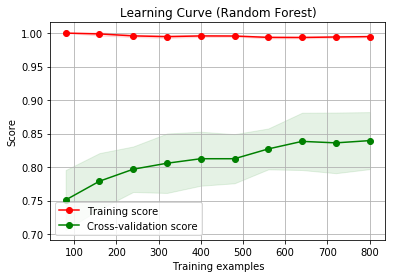

In [87]:
# TODO 9 
# plot learning curves for Random Forest Model (for train and test)
# hint: look at sklearn.learning_curve module. Look at the docs
# use Random Forest with 500 trees, 10-fold cross-validation for roc_auc scoring.
# 
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(RandomForestClassifier(n_estimators=500, random_state=SEED), 'Learning Curve (Random Forest)', 
                    X, y, cv=10)

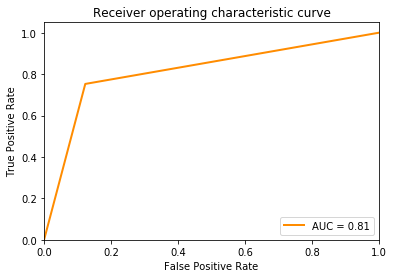

In [91]:
# TODO 10
# plot roc auc curve for Random Forest for test dataset
# hint: use roc_curve and auc functions from sklearn.metrics
# use Random Forest with 5000 trees
# use test_size=0.25

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

model_rf = RandomForestClassifier(n_estimators=5000, random_state=SEED)
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)

plt.figure()
plt.title('Receiver operating characteristic curve')
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='AUC = %0.2f' % auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Question 4: What is the roc auc score on test dataset ? 

In [92]:
auc

0.8148056244830438